# HW 11 Part B Minh Nguyen

## K-means Clustering

In [156]:
import numpy as np
import pandas as pd
import cv2
import collections
import seaborn as sns
import matplotlib.pyplot as plt
# from skimage import filters
# from skimage import util
from sklearn.preprocessing import MinMaxScaler 
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import MeanShift, estimate_bandwidth

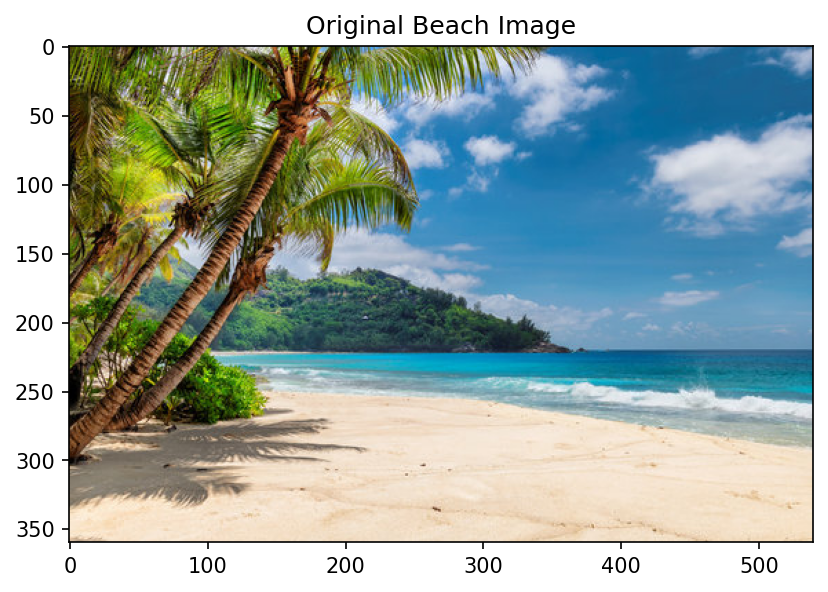

In [157]:
imageName = 'beach.jpg'
image = plt.imread(imageName)
plt.figure(dpi=150)
plt.title('Original Beach Image')
plt.imshow(image)

In [158]:
# RGB pixels as Feature Vectors
index = pd.MultiIndex.from_product(
    (*map(range, image.shape[:2]), ('r', 'g', 'b')),
    names=('row', 'col', None))
df_1 = pd.Series(image.flatten(), index=index)
df_1 = df_1.unstack()
df_1 = df_1.reset_index().reindex(columns=['col','row',   'r','g','b'])
df_1.head(10)

,col,row,r,g,b
0,0,0,98,81,25
1,1,0,76,78,0
2,2,0,80,65,8
3,3,0,67,89,7
4,4,0,75,71,8
5,5,0,102,137,7
6,6,0,92,101,18
7,7,0,50,69,5
8,8,0,100,113,23
9,9,0,121,108,66


In [159]:
# Vector which have only image RGB pixels
df_2 = df_1[['r', 'g', 'b']]
df_2.head(10)

,r,g,b
0,98,81,25
1,76,78,0
2,80,65,8
3,67,89,7
4,75,71,8
5,102,137,7
6,92,101,18
7,50,69,5
8,100,113,23
9,121,108,66


In [160]:
# Normalize data points
nd_1 = MinMaxScaler(feature_range=(0, 1)).fit_transform(df_1)
nd_2 = MinMaxScaler(feature_range=(0, 1)).fit_transform(df_2)

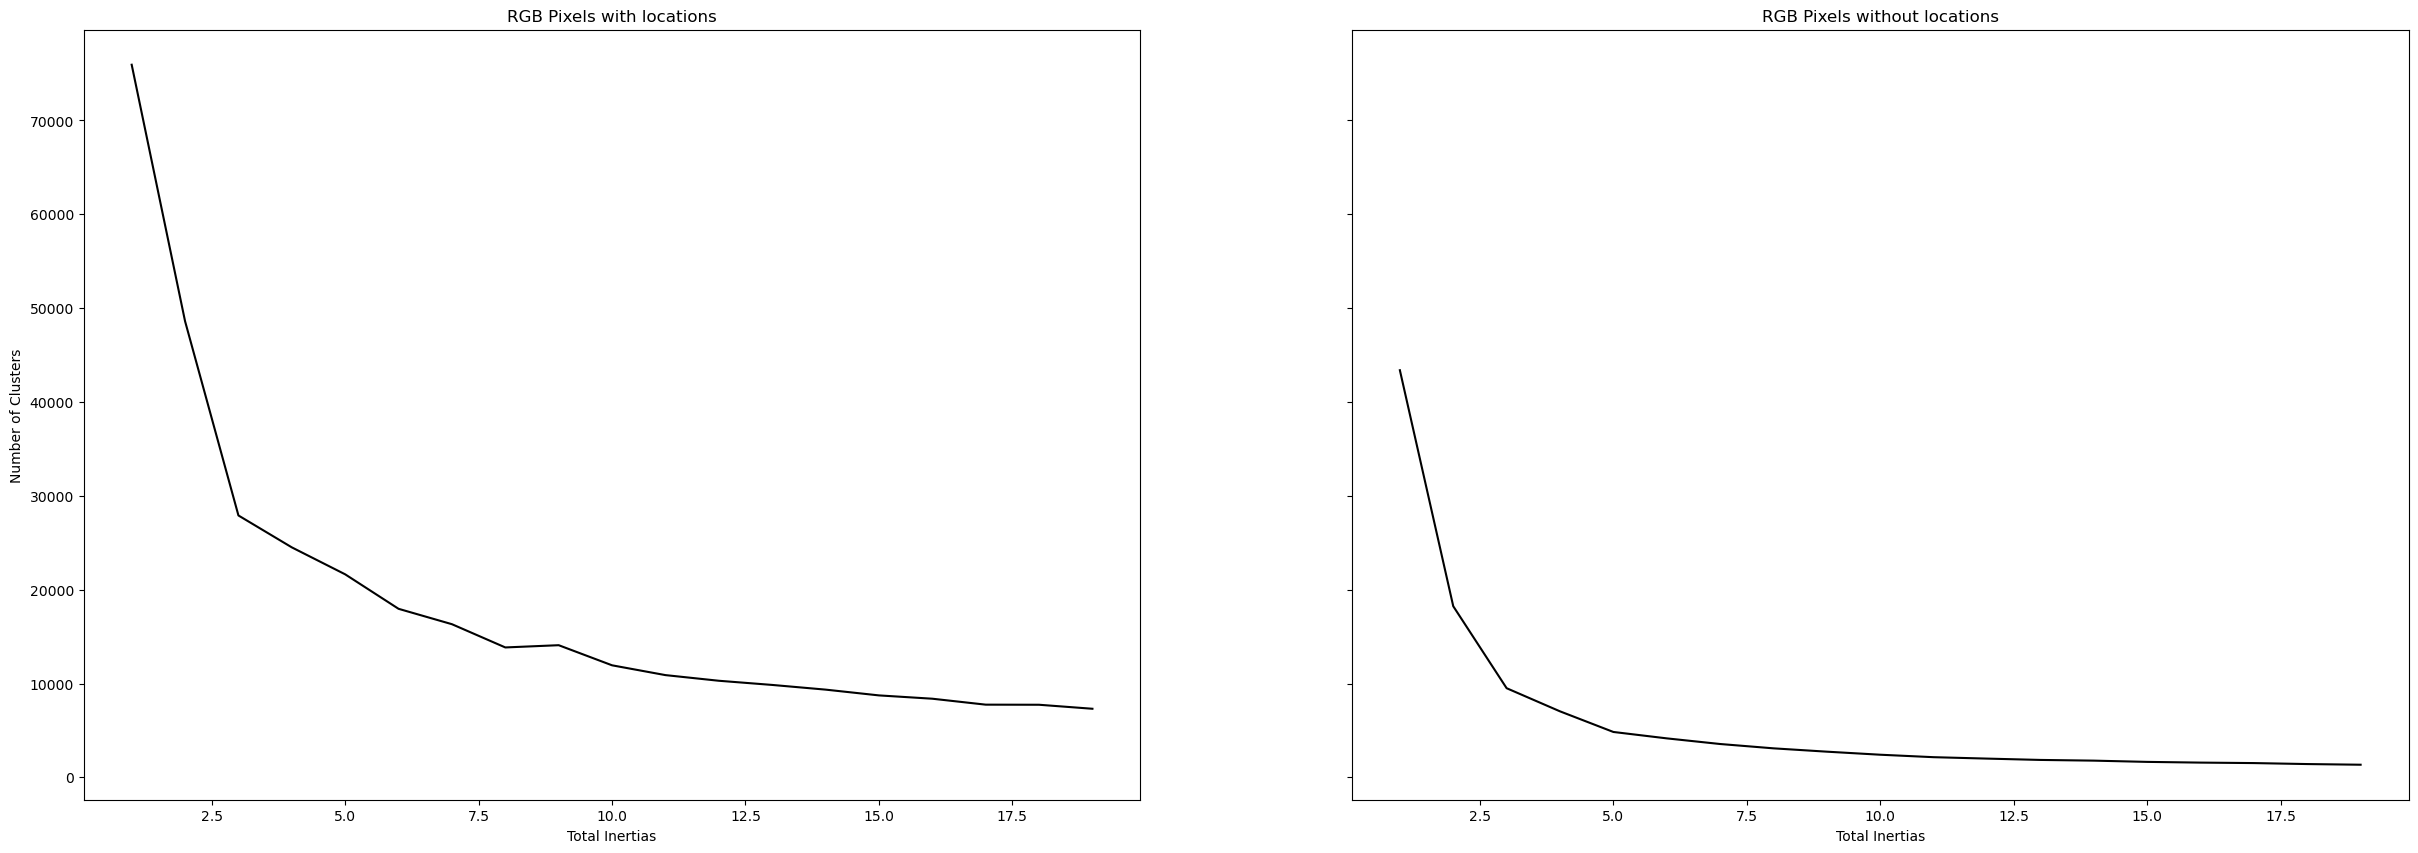

In [161]:
total_inertias_1 = [KMeans(n_clusters=i).fit(nd_1).inertia_ for i in range(1, 20)]
total_inertias_2 = [KMeans(n_clusters=i).fit(nd_2).inertia_ for i in range(1, 20)]

fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(30,10))
ax1.plot(range(1, 20), total_inertias_1, c='black')
ax1.set(xlabel='Total Inertias', ylabel='Number of Clusters', title='RGB Pixels with locations')
ax2.plot(range(1, 20), total_inertias_2, c='black')
ax2.set(xlabel='Total Inertias', title='RGB Pixels without locations');
# plt.savefig('elbow_result.jpg')
plt.show()

- The optimal value of k (number of clusters) is 5.

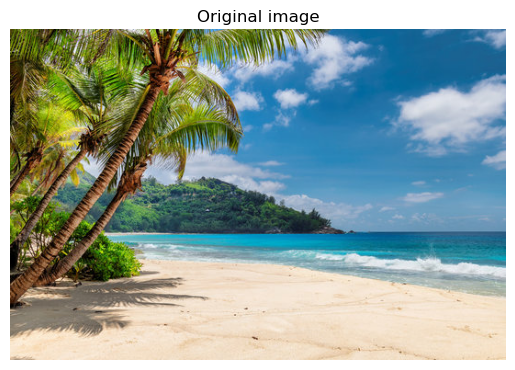

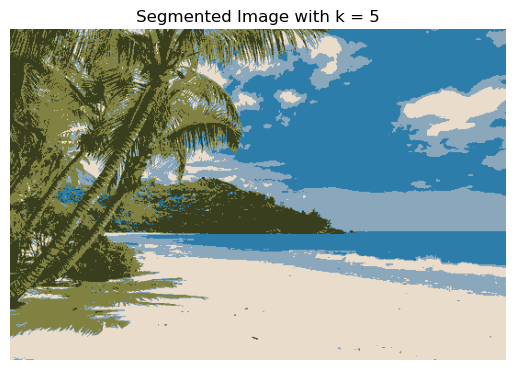

In [174]:
# Using k-means clustering to segment the image into k=5 clusters
k = 5

# Reshaping the image into a 2D array of pixels and 3 color values (RGB)
pixel_vals = image.reshape((-1,3))
 
# Convert to float type
pixel_vals = np.float32(pixel_vals)

retval, labels, centers = cv2.kmeans(pixel_vals, k, None, (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2), 10, cv2.KMEANS_RANDOM_CENTERS)

# Convert the centers to 8-bit values
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]

# Reshape the segmented data into the original image dimensions
segmented_image = segmented_data.reshape((image.shape))

# Display the original image and the segmented image
plt.figure(1)
plt.clf()
plt.axis('off')
plt.title('Original image', loc='center')
plt.imshow(image)

plt.figure(2)
plt.clf()
plt.axis('off')
plt.title(f'Segmented Image with k = {k}')
plt.imshow(segmented_image)

- Clustering works well with k = 5. It's able to separate the pixels into 5 distinct clusters. If we increase k, the clusters will be more granular and the image will be more detailed, but I noticed only after k = 15, the image starts to look like the original image.

## Mean-Shift Clustering

In [183]:
# Flatten the image
flat_image = image.reshape((-1, 3))

In [184]:
# Create the feature space [L, a, b, x, y]
height, width, _ = image.shape
x, y = np.meshgrid(np.arange(width), np.arange(height))
flat_image_with_coordinates = np.column_stack([flat_image, x.flatten(), y.flatten()])

In [185]:
# Calculate the best bandwidth by feature vector
# calculate gaussian kernel depending on data
bandwidth = estimate_bandwidth(flat_image_with_coordinates, quantile=.04, n_jobs=-1)

In [186]:
# Perform Mean Shift clustering
mean_shift = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=True)
mean_shift.fit(flat_image_with_coordinates)
labels = mean_shift.labels_

In [187]:
# Reshape the labels to the original image shape
segmented_image = labels.reshape((height, width))

In [188]:
# Cluster centers
cluster_centers = mean_shift.cluster_centers_[:, :3]  # Use only the first 3 columns for RGB values
# Generate a colored segmented image
colored_segmented_image = np.zeros((height, width, 3), dtype=np.uint8)
for i in range(height):
    for j in range(width):
        colored_segmented_image[i, j] = cluster_centers[segmented_image[i, j]]

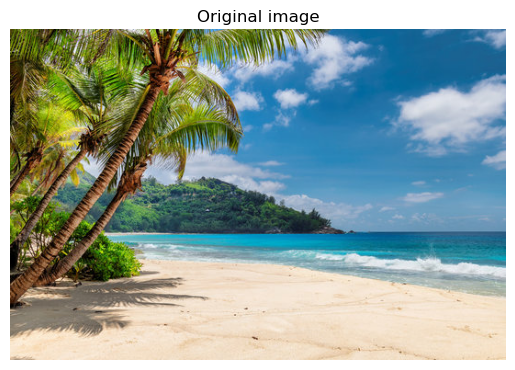

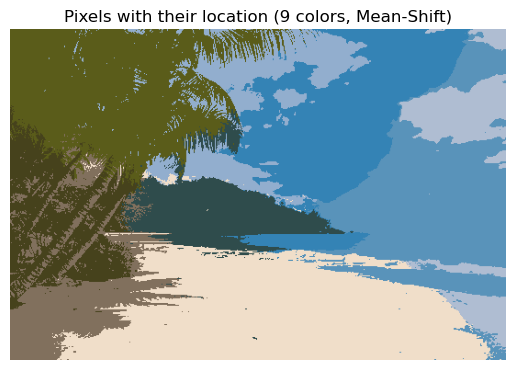

In [189]:
# Showing the images
plt.figure(1)
plt.clf()
plt.axis('off')
plt.title('Original image', loc='center')
plt.imshow(image)

plt.figure(2)
plt.clf()
plt.axis('off')
plt.title('Pixels with their location ({} colors, Mean-Shift)'.format(len(mean_shift.cluster_centers_)), loc='center')
plt.imshow(colored_segmented_image);

- Results: Mean-shift clustering is able to distinguish the pixels in clusters of 9 different colors. We can clearly see the segmentation of the image into 9 distinct colors. It's easy to see the image pattern and the color distribution.
- Both K-means and Mean-shift clustering are able to segment the image into different clusters pretty well. However, Mean-shift clustering is able to segment the image into a little more clusters than K-means clustering.

4. Is image thresholding a form of unsupervised image segmentation?
- Yes, image thresholding is a form of unsupervised image segmentation. It involves creating a binary image by applying a threshold value to the pixel intensities. The threshold value is chosen based on the distribution of pixel intensities. It does not require any labeled data or training.

5. What are some differences between K-means and Mean-Shift?
- K-means clustering requires the number of clusters to be specified in advance, while Mean-shift clustering does not require the number of clusters to be specified.
- K-means clustering is sensitive to the initial choice of cluster centers, while Mean-shift clustering is not sensitive to the initial choice of cluster centers.
- K-means clustering is computationally faster than Mean-shift clustering.

6. What are some of their limitations?
- K-means clustering is sensitive to the initial choice of cluster centers, which can lead to suboptimal solutions.
- Mean-shift clustering can be computationally expensive for large datasets, as it involves calculating the pairwise distances between all data points.
- Mean-shift clustering may not be able to handle outliers or data with a high variance in intensity.